<a href="https://colab.research.google.com/github/Shinoy-12/Chatbot-song-link-/blob/master/Forecast_Order_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
df = pd.read_csv('Historical Product Demand.csv', parse_dates=['Date'])

The objective is to forecast demand for customer orders using an appropriate model.

There are multiple ways of forecasting demand, with linear models being one of the most popular choice (tried/tested) for data that exhibits a linear trend and/or when the residuals have a normal distribution. 


I have gone with a tried and tested ARIMA model to forecast the order demand.

In [0]:
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy

***STEPS/Work Flow***

* Import data and libraries: Self Explanatory
* Explore the Dataset: Check Nulls, Skew, Data Types, Univariate and Bivariate Analysis.
* Explore the Dataset as a Time Series: Min/Max Dates, Check Seasonality, Trends etc.
* ARIMA Model
* The END.

In [0]:
print (df.isna().sum())

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64


In [0]:
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
...,...,...,...,...,...
1037331,Product_1791,Whse_J,Category_006,2016-04-27,1000
1037332,Product_1974,Whse_J,Category_006,2016-04-27,1
1037333,Product_1787,Whse_J,Category_006,2016-04-28,2500
1037334,Product_0901,Whse_J,Category_023,2016-10-07,50


In [0]:
df.sort_values('Date')[10:20]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
75193,Product_0642,Whse_C,Category_019,2011-10-31,3
121820,Product_0202,Whse_A,Category_007,2011-11-04,(100)
121819,Product_0202,Whse_A,Category_007,2011-11-04,(400)
131028,Product_2143,Whse_S,Category_009,2011-11-18,(25)
131031,Product_0131,Whse_S,Category_021,2011-11-18,(12)
131032,Product_0288,Whse_S,Category_021,2011-11-18,(50)
44450,Product_0980,Whse_A,Category_028,2011-11-18,4000
131027,Product_2138,Whse_S,Category_009,2011-11-18,(49)
131026,Product_2137,Whse_S,Category_009,2011-11-18,(25)
44795,Product_0965,Whse_A,Category_006,2011-11-18,1


In [0]:
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

#Next step is to change the data type.
df['Order_Demand'] = df['Order_Demand'].astype('int64')

In [0]:
df['Date'].min() , df['Date'].max()

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [0]:
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

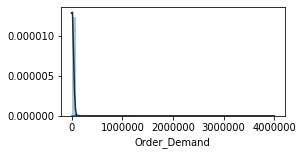

In [0]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 4,2

sb.distplot(df['Order_Demand'], fit=norm)

In [0]:
#The data is highly skewed, but since we'll be applying ARIMA, it's fine.
df['Order_Demand'].skew()

31.506080242695006

In [0]:
#Warehouse shipping by orders.
df['Warehouse'].value_counts().sort_values(ascending = False)

Whse_J    764215
Whse_A    142197
Whse_S     88024
Whse_C     42207
Name: Warehouse, dtype: int64

In [0]:
#The amount of orders shipped by each warehouse.
df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)
#Warehouse J is clearly shipping most orders. Although S is shipping more quantity within fewer requested orders.

,Order_Demand
Warehouse,
Whse_J,3362742530
Whse_S,1033121811
Whse_C,582004179
Whse_A,147646550


33


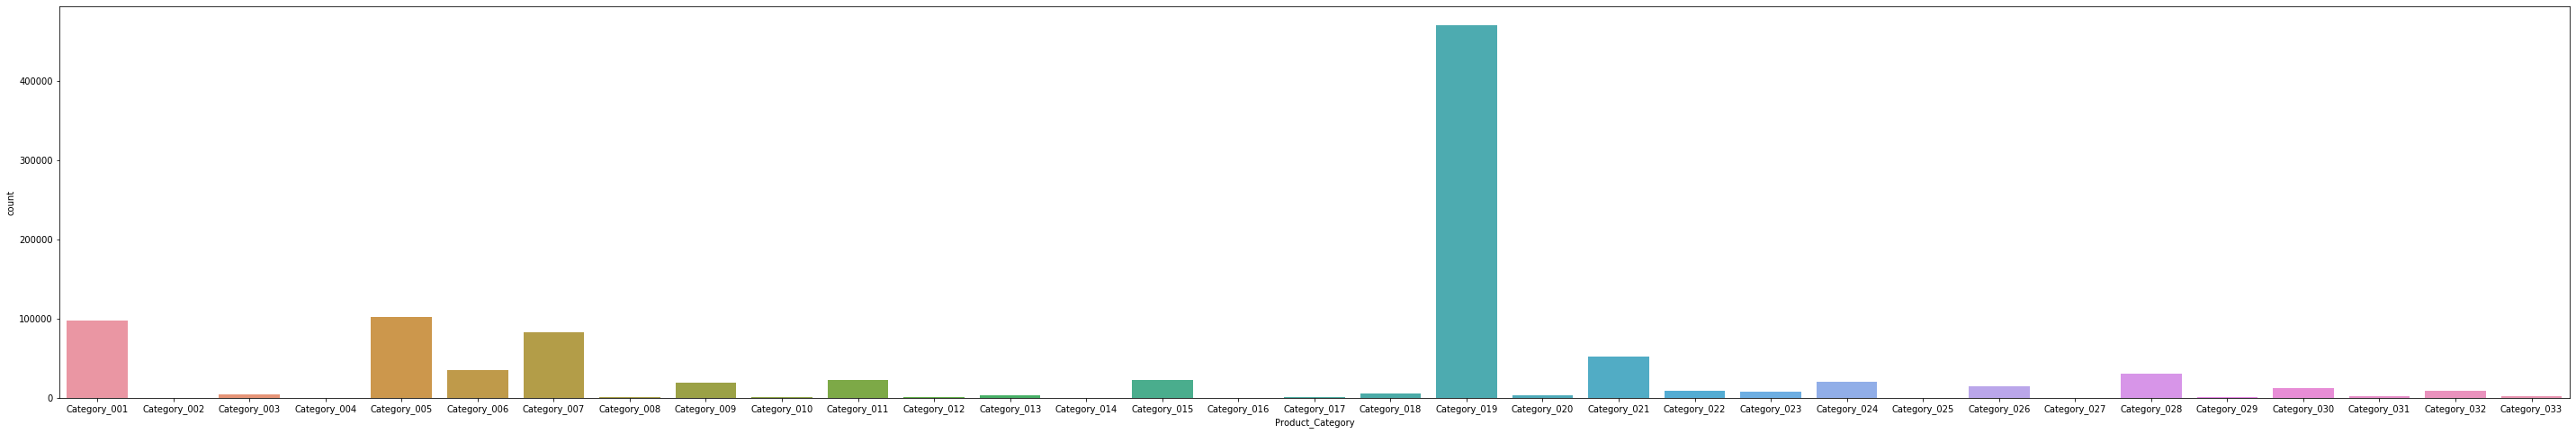

In [0]:
#Product Category.

print (len(df['Product_Category'].value_counts()))

rcParams['figure.figsize'] = 50,8
sb.countplot(df['Product_Category'].sort_values(ascending = True))

#There's a lot of orders on category19.

In [0]:
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
#This gives us the total orders placed on each day.

In [0]:
#Index the date
df = df.set_index('Date')
df.index #Lets check the index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

In [0]:
#Averages daily sales value for the month, and we are using the start of each month as the timestamp.
y = df['Order_Demand'].resample('MS').mean()

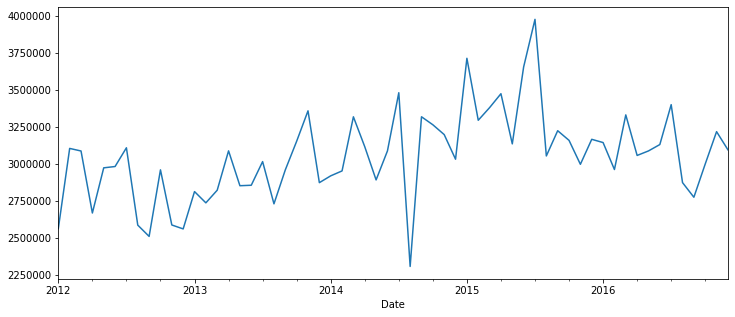

In [0]:
y.plot(figsize=(12,5))
plt.show()

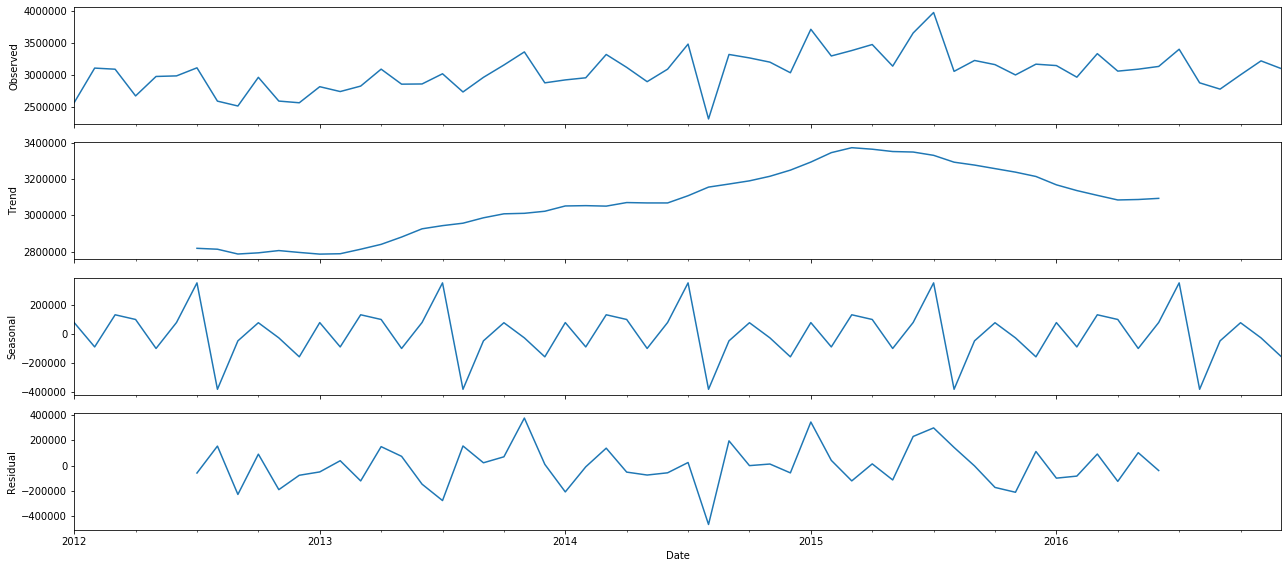

In [0]:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [0]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [0]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1932.23655778549
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.9275832124354
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1338.8201294951011
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3099.295103848722
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1366.5117513512635
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1340.8450308457732
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.6756022859483
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3004.669136926405
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1862.087487804522
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1471.1838032700675
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1305.3289813345482
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3016.8617915994814
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1529.1005721650718
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.6395590277837
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1020.6347629759122
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2950.0556233357447
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1648.7378898187837
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1309.86532921019

In [0]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.368     -0.666      0.505      -0.966       0.476
ma.L1         -0.4385      0.325     -1.348      0.178      -1.076       0.199
ar.S.L12      -0.4568      0.208     -2.192      0.028      -0.865      -0.048
sigma2      1.018e+11   9.55e-13   1.06e+23      0.000    1.02e+11    1.02e+11


Interpreting the table:

coeff: Shows weight/impotance how each feature impacts the time series. Pvalue: Shows the significance of each feature weight. Can test hypothesis using this. If p value is <.05 then they are statitically significant.

Refresher on null hyp and pvalues. By default we take the null hyp as 'there is no relationship bw them' If p value < .05 (significance level) then you reject the Null Hypthesis If p value > .05 , then you fail to reject the Null Hypothesis.

So, if the p-value is < .05 then there is a relationship between the response and predictor. Hence, significant.

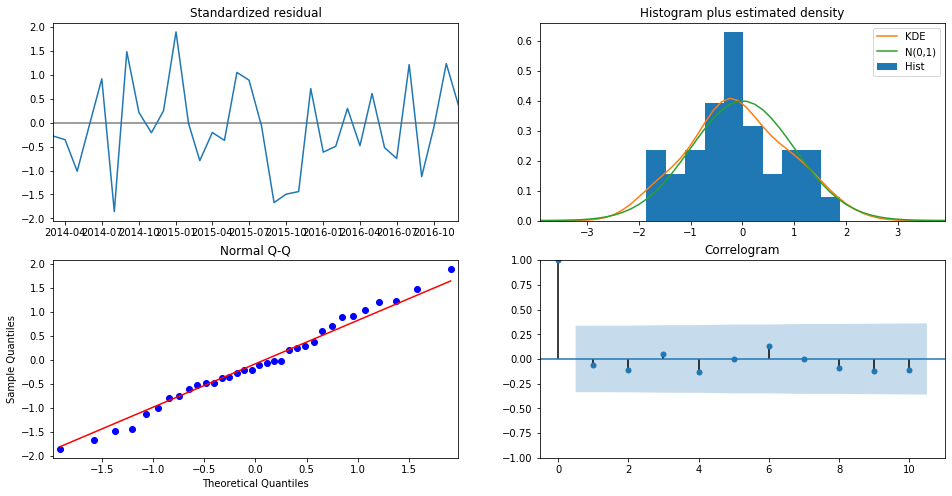

In [0]:
#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#What to look for?
#1. Residuals SHOULD be Normally Distributed ; Check
#Top Right: The (orange colored) KDE line should be closely matched with green colored N(0,1) line. This is the standard notation
#for normal distribution with mean 0 and sd 1.
#Bottom Left: The qq plot shows the ordered distribution of residuals (blue dots) follows the linear trend of the samples 
#taken from a standard normal distribution with N(0, 1). 

#2. #Residuals are not correlated; Check
#Top Left: The standard residuals don’t display any obvious seasonality and appear to be white noise. 
#Bottom Right: The autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have 
#low correlation with its own lagged versions.


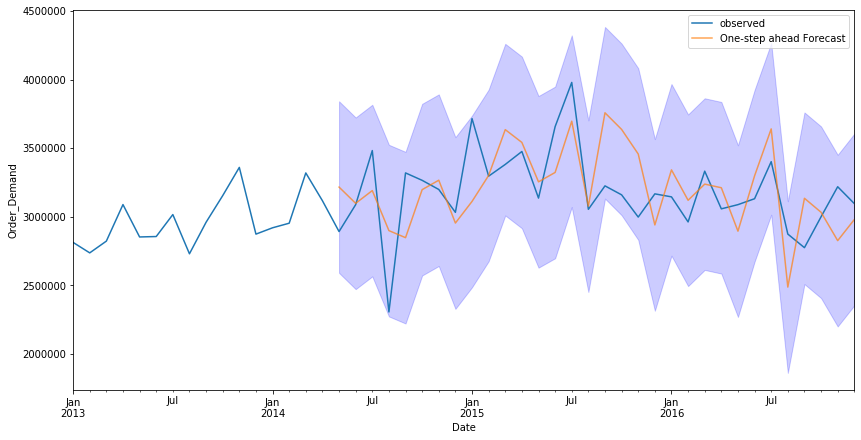

In [0]:
pred = results.get_prediction(start=pd.to_datetime('2014-05-01'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()
#Takeaway: The forecats seems to be fitting well to the data. The Blue/purple thicker plot shows the confidence level in the forecasts.

In [0]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))



MSE 55459437816.57


In [0]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 235498.28
